Files already downloaded and verified
Files already downloaded and verified

Training on CIFAR-10...
Without Dropout:
Epoch 1/10 - Train Loss: 1.4503, Validation Loss: 1.1214, Accuracy: 59.21%
Epoch 2/10 - Train Loss: 0.9425, Validation Loss: 0.7096, Accuracy: 75.27%
Epoch 3/10 - Train Loss: 0.7155, Validation Loss: 0.6006, Accuracy: 79.13%
Epoch 4/10 - Train Loss: 0.5679, Validation Loss: 0.4280, Accuracy: 85.58%
Epoch 5/10 - Train Loss: 0.4463, Validation Loss: 0.3130, Accuracy: 89.49%
Epoch 6/10 - Train Loss: 0.3486, Validation Loss: 0.2469, Accuracy: 91.74%
Epoch 7/10 - Train Loss: 0.2584, Validation Loss: 0.1819, Accuracy: 93.86%
Epoch 8/10 - Train Loss: 0.1987, Validation Loss: 0.1579, Accuracy: 94.66%
Epoch 9/10 - Train Loss: 0.1541, Validation Loss: 0.1160, Accuracy: 96.15%
Epoch 10/10 - Train Loss: 0.1399, Validation Loss: 0.0960, Accuracy: 96.82%
With Dropout:
Epoch 1/10 - Train Loss: 1.5049, Validation Loss: 1.1157, Accuracy: 59.64%
Epoch 2/10 - Train Loss: 1.0354, Validatio

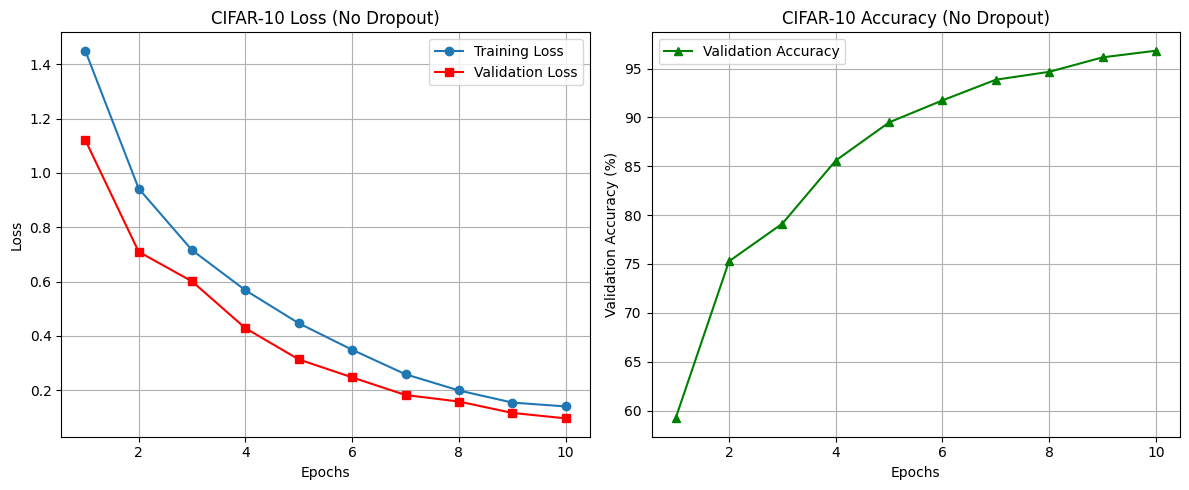

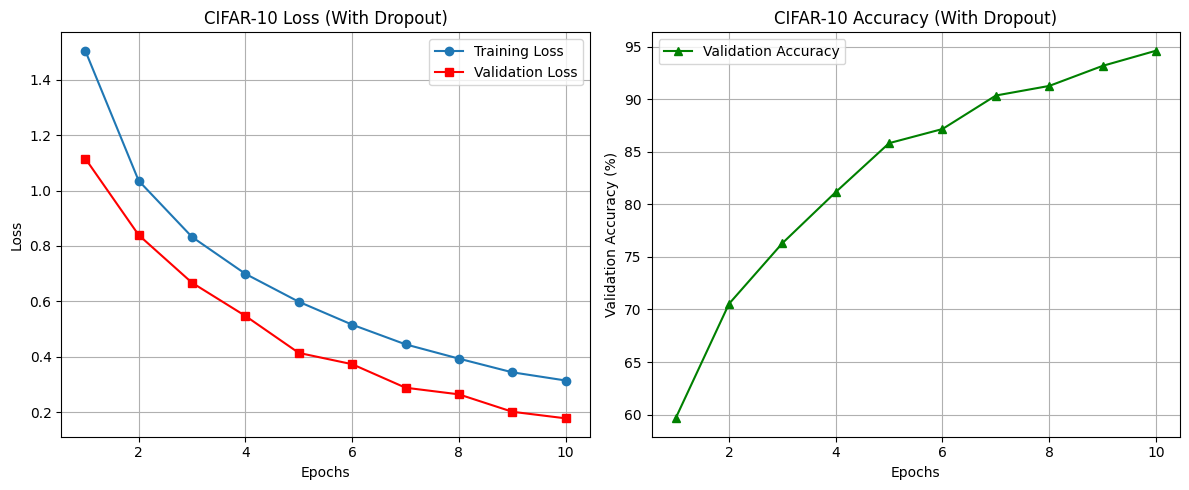


Training on CIFAR-100...
Without Dropout:
Epoch 1/10 - Train Loss: 3.9110, Validation Loss: 3.4096, Accuracy: 16.50%
Epoch 2/10 - Train Loss: 3.1835, Validation Loss: 2.8735, Accuracy: 27.04%
Epoch 3/10 - Train Loss: 2.7627, Validation Loss: 2.4837, Accuracy: 35.40%
Epoch 4/10 - Train Loss: 2.4525, Validation Loss: 2.1625, Accuracy: 42.46%
Epoch 5/10 - Train Loss: 2.1934, Validation Loss: 1.9277, Accuracy: 47.20%
Epoch 6/10 - Train Loss: 1.9685, Validation Loss: 1.7003, Accuracy: 53.16%
Epoch 7/10 - Train Loss: 1.7655, Validation Loss: 1.4824, Accuracy: 58.59%
Epoch 8/10 - Train Loss: 1.5634, Validation Loss: 1.3038, Accuracy: 63.01%
Epoch 9/10 - Train Loss: 1.3668, Validation Loss: 1.0936, Accuracy: 68.46%
Epoch 10/10 - Train Loss: 1.1818, Validation Loss: 0.8813, Accuracy: 74.24%
With Dropout:
Epoch 1/10 - Train Loss: 4.1619, Validation Loss: 3.6944, Accuracy: 12.28%
Epoch 2/10 - Train Loss: 3.6207, Validation Loss: 3.2223, Accuracy: 21.07%
Epoch 3/10 - Train Loss: 3.3016, Validatio

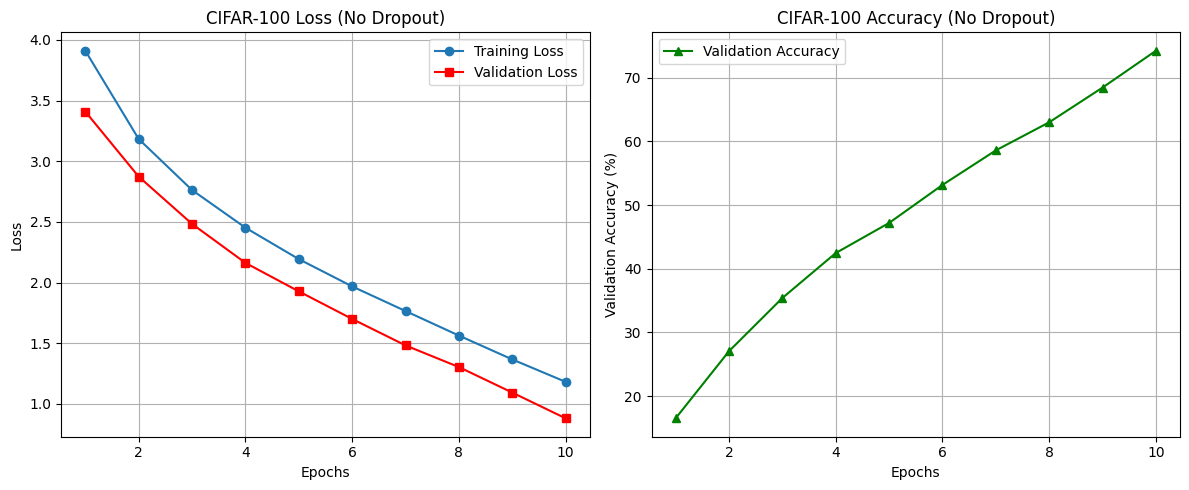

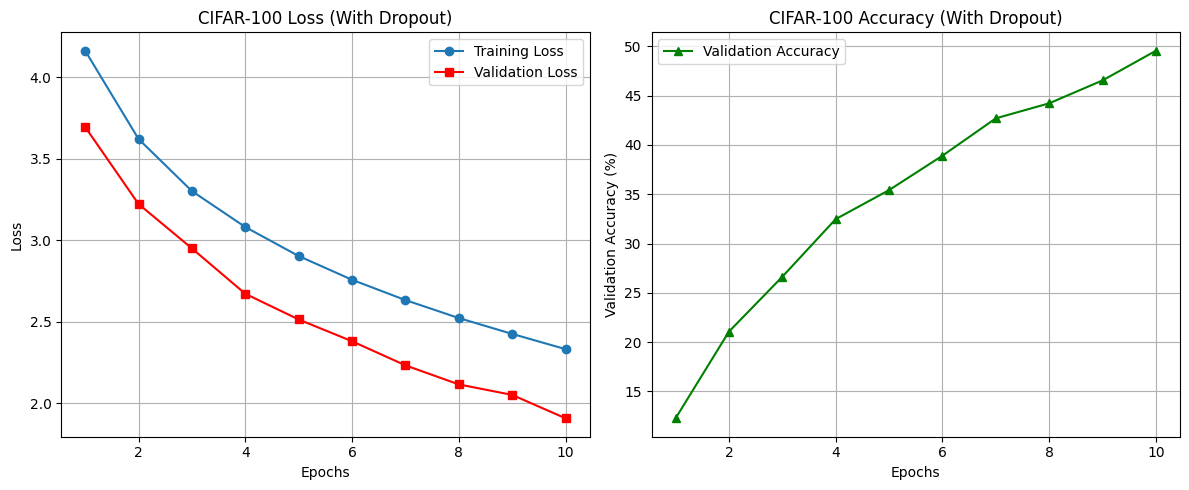


Original AlexNet Parameters: 60,000,000
Modified AlexNet Parameters: 5,686,154


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a modified AlexNet for CIFAR-10 and CIFAR-100
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout=False):
        super(ModifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),
            
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),
            
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training function
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100.0 * correct / total)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.2f}%")
    
    return train_losses, val_losses, val_accuracies

# Function to plot results
def plot_results(epochs, train_losses, val_losses, val_accuracies, dataset_name, dropout):
    plt.figure(figsize=(12, 5))

    # Loss Plot (Train & Validation)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', linestyle='-', label='Validation Loss', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{dataset_name} Loss ({'With' if dropout else 'No'} Dropout)")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), val_accuracies, marker='^', linestyle='-', label='Validation Accuracy', color='g')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy (%)")
    plt.title(f"{dataset_name} Accuracy ({'With' if dropout else 'No'} Dropout)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Load CIFAR-10 and CIFAR-100 datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

datasets_dict = {
    "CIFAR-10": datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    "CIFAR-100": datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
}

# Compare models with and without dropout for both datasets
for dataset_name, dataset in datasets_dict.items():
    print(f"\nTraining on {dataset_name}...")
    num_classes = 10 if dataset_name == "CIFAR-10" else 100
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(datasets_dict[dataset_name.replace("train", "test")], batch_size=64, shuffle=False)
    
    print("Without Dropout:")
    model_no_dropout = ModifiedAlexNet(num_classes=num_classes, dropout=False)
    train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout = train_model(model_no_dropout, train_loader, val_loader)
    
    print("With Dropout:")
    model_dropout = ModifiedAlexNet(num_classes=num_classes, dropout=True)
    train_losses_dropout, val_losses_dropout, val_accuracies_dropout = train_model(model_dropout, train_loader, val_loader)

    # Plot the results
    plot_results(10, train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout, dataset_name, dropout=False)
    plot_results(10, train_losses_dropout, val_losses_dropout, val_accuracies_dropout, dataset_name, dropout=True)

# Report number of parameters in modified and original AlexNet
original_alexnet_params = 60000000  # Approximate parameter count from AlexNet paper
modified_alexnet_params = sum(p.numel() for p in ModifiedAlexNet().parameters())
print(f"\nOriginal AlexNet Parameters: {original_alexnet_params:,}")
print(f"Modified AlexNet Parameters: {modified_alexnet_params:,}")


Files already downloaded and verified
Files already downloaded and verified

Training on CIFAR-10...
Without Dropout:
Epoch 1/10 - Train Loss: 1.5301, Validation Loss: 1.1011, Accuracy: 60.78%
Epoch 2/10 - Train Loss: 0.9679, Validation Loss: 0.7865, Accuracy: 71.91%
Epoch 3/10 - Train Loss: 0.7319, Validation Loss: 0.5557, Accuracy: 80.58%
Epoch 4/10 - Train Loss: 0.5826, Validation Loss: 0.4450, Accuracy: 84.51%
Epoch 5/10 - Train Loss: 0.4727, Validation Loss: 0.3567, Accuracy: 87.67%
Epoch 6/10 - Train Loss: 0.3846, Validation Loss: 0.2608, Accuracy: 90.89%
Epoch 7/10 - Train Loss: 0.3020, Validation Loss: 0.2376, Accuracy: 92.02%
Epoch 8/10 - Train Loss: 0.2492, Validation Loss: 0.1990, Accuracy: 93.35%
Epoch 9/10 - Train Loss: 0.2019, Validation Loss: 0.1441, Accuracy: 95.13%
Epoch 10/10 - Train Loss: 0.1693, Validation Loss: 0.1128, Accuracy: 96.28%
With Dropout:
Epoch 1/10 - Train Loss: 1.6458, Validation Loss: 1.2132, Accuracy: 56.02%
Epoch 2/10 - Train Loss: 1.1347, Validatio

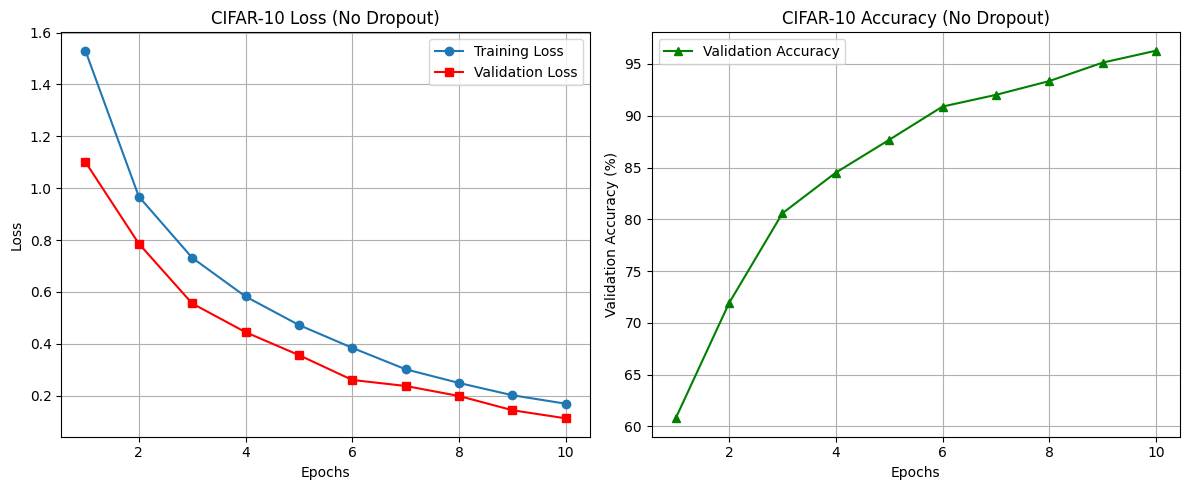

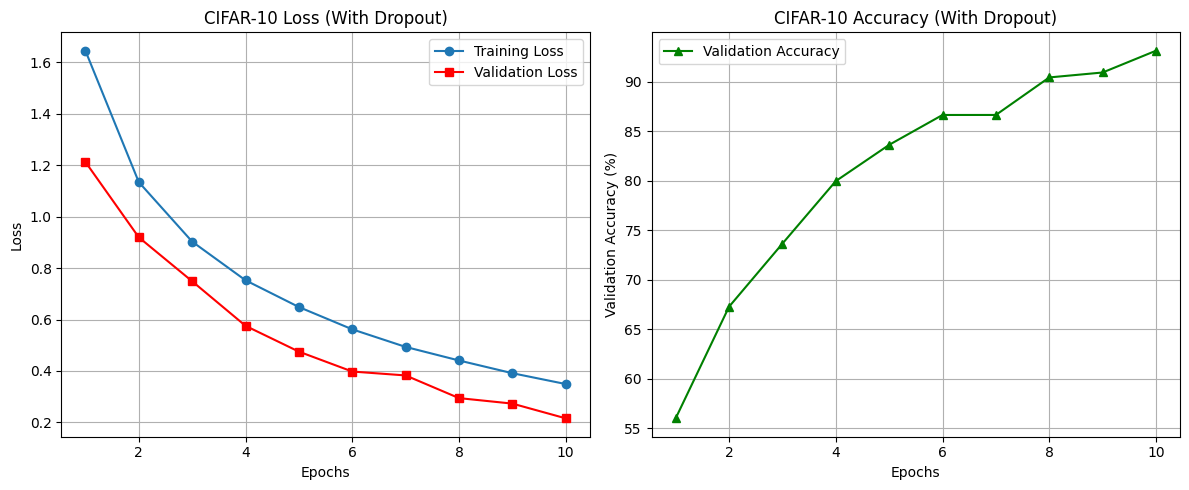


Training on CIFAR-100...
Without Dropout:
Epoch 1/10 - Train Loss: 4.1778, Validation Loss: 3.7894, Accuracy: 10.05%
Epoch 2/10 - Train Loss: 3.5695, Validation Loss: 3.3497, Accuracy: 18.18%
Epoch 3/10 - Train Loss: 3.1812, Validation Loss: 2.9245, Accuracy: 26.70%
Epoch 4/10 - Train Loss: 2.8808, Validation Loss: 2.6317, Accuracy: 32.22%
Epoch 5/10 - Train Loss: 2.6271, Validation Loss: 2.3922, Accuracy: 37.19%
Epoch 6/10 - Train Loss: 2.4074, Validation Loss: 2.1526, Accuracy: 42.89%
Epoch 7/10 - Train Loss: 2.2012, Validation Loss: 1.9264, Accuracy: 48.34%
Epoch 8/10 - Train Loss: 1.9827, Validation Loss: 1.6765, Accuracy: 53.68%
Epoch 9/10 - Train Loss: 1.7715, Validation Loss: 1.4623, Accuracy: 59.80%
Epoch 10/10 - Train Loss: 1.5556, Validation Loss: 1.2200, Accuracy: 65.67%
With Dropout:
Epoch 1/10 - Train Loss: 4.3029, Validation Loss: 3.9066, Accuracy: 8.57%
Epoch 2/10 - Train Loss: 3.7419, Validation Loss: 3.3466, Accuracy: 18.17%
Epoch 3/10 - Train Loss: 3.3608, Validation

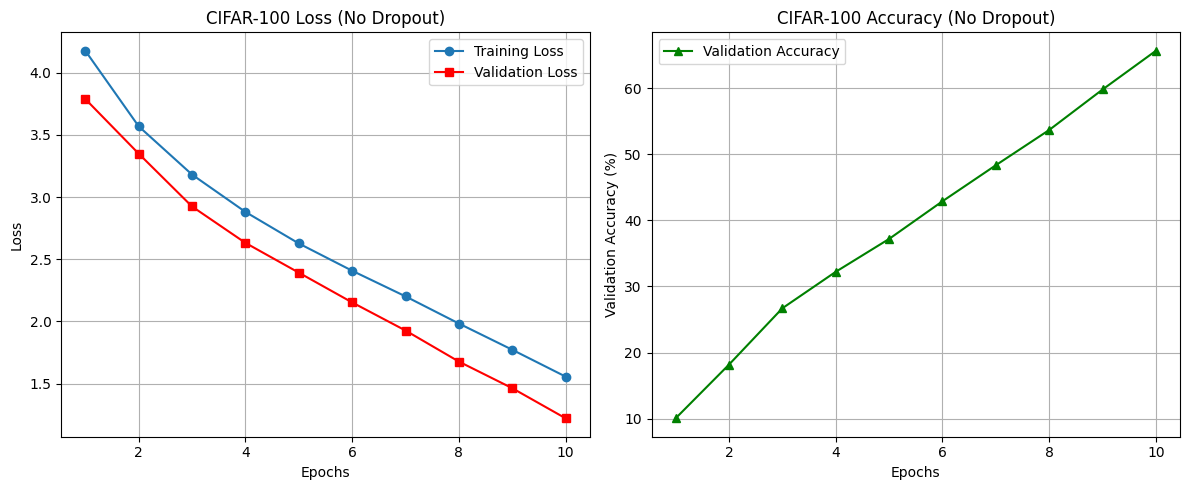

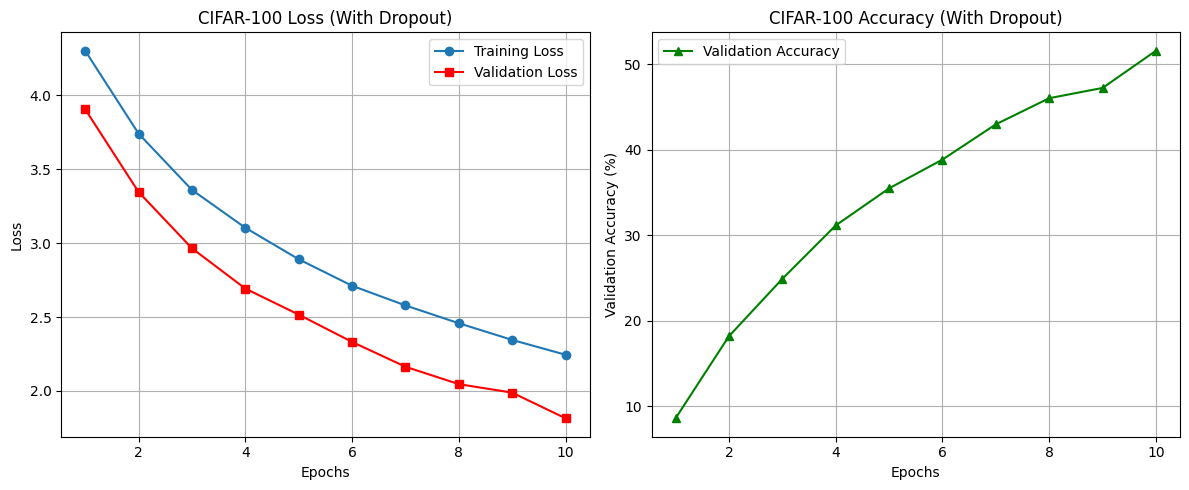


Original VGG Parameters: 138,000,000
Modified VGG Parameters: 5,870,666


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a modified VGG-Net for CIFAR-10 and CIFAR-100
class ModifiedVGG(nn.Module):
    def __init__(self, num_classes=10, dropout=False):
        super(ModifiedVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64,128,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),
            
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),
            
            nn.Linear(512,num_classes),
        )

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

# Load CIFAR-10 and CIFAR-100 datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
datasets_dict = {
    "CIFAR-10": datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    "CIFAR-100": datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
}

# Training function
def train_model(model, train_loader,val_loader, epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        # Validation function
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100.0 * correct / total)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.2f}%")
    
    return train_losses, val_losses, val_accuracies

# Function to plot results
def plot_results(epochs, train_losses, val_losses, val_accuracies, dataset_name, dropout):
    plt.figure(figsize=(12, 5))

    # Loss Plot (Train & Validation in one graph)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', linestyle='-', label='Validation Loss', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{dataset_name} Loss ({'With' if dropout else 'No'} Dropout)")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), val_accuracies, marker='^', linestyle='-', label='Validation Accuracy', color='g')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy (%)")
    plt.title(f"{dataset_name} Accuracy ({'With' if dropout else 'No'} Dropout)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()  # Ensure plots show up in VS Code

# Compare models with and without dropout for both datasets
for dataset_name, dataset in datasets_dict.items():
    print(f"\nTraining on {dataset_name}...")
    num_classes = 10 if dataset_name == "CIFAR-10" else 100
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(datasets_dict[dataset_name.replace("train", "test")], batch_size=64, shuffle=False)
    
    print("Without Dropout:")
    model_no_dropout = ModifiedVGG(num_classes=num_classes, dropout=False)
    train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout = train_model(model_no_dropout, train_loader, val_loader)
    
    print("With Dropout:")
    model_dropout = ModifiedVGG(num_classes=num_classes, dropout=True)
    train_losses_dropout, val_losses_dropout, val_accuracies_dropout = train_model(model_dropout, train_loader, val_loader)

    # Plot the results
    plot_results(10, train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout, dataset_name, dropout=False)
    plot_results(10, train_losses_dropout, val_losses_dropout, val_accuracies_dropout, dataset_name, dropout=True)

# Report number of parameters in modified and original VGG
original_vgg_params = 138000000  # Approximate parameter count from VGG paper
modified_vgg_params = sum(p.numel() for p in ModifiedVGG().parameters())
print(f"\nOriginal VGG Parameters: {original_vgg_params:,}")
print(f"Modified VGG Parameters: {modified_vgg_params:,}")


Training ResNet-11 on CIFAR-10...
Epoch 1/20 is starting...
Epoch 2/20 is starting...
Epoch 3/20 is starting...
Epoch 4/20 is starting...
Epoch 5/20 is starting...
Epoch 6/20 is starting...
Epoch 7/20 is starting...
Epoch 8/20 is starting...
Epoch 9/20 is starting...
Epoch 10/20 is starting...
Epoch 11/20 is starting...
Epoch 12/20 is starting...
Epoch 13/20 is starting...
Epoch 14/20 is starting...
Epoch 15/20 is starting...
Epoch 16/20 is starting...
Epoch 17/20 is starting...
Epoch 18/20 is starting...
Epoch 19/20 is starting...
Epoch 20/20 is starting...


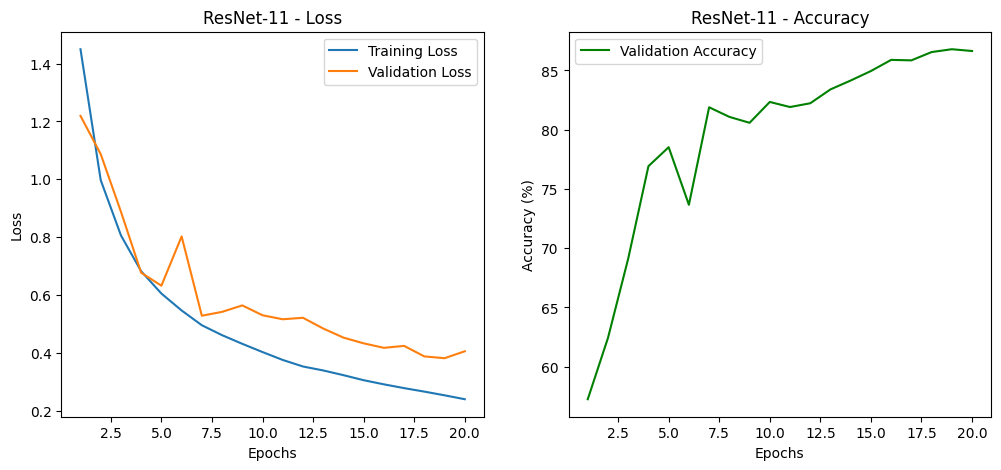

Training ResNet-18 on CIFAR-10...
Epoch 1/20 is starting...
Epoch 2/20 is starting...
Epoch 3/20 is starting...
Epoch 4/20 is starting...
Epoch 5/20 is starting...
Epoch 6/20 is starting...
Epoch 7/20 is starting...
Epoch 8/20 is starting...
Epoch 9/20 is starting...
Epoch 10/20 is starting...
Epoch 11/20 is starting...
Epoch 12/20 is starting...
Epoch 13/20 is starting...
Epoch 14/20 is starting...
Epoch 15/20 is starting...
Epoch 16/20 is starting...
Epoch 17/20 is starting...
Epoch 18/20 is starting...
Epoch 19/20 is starting...
Epoch 20/20 is starting...


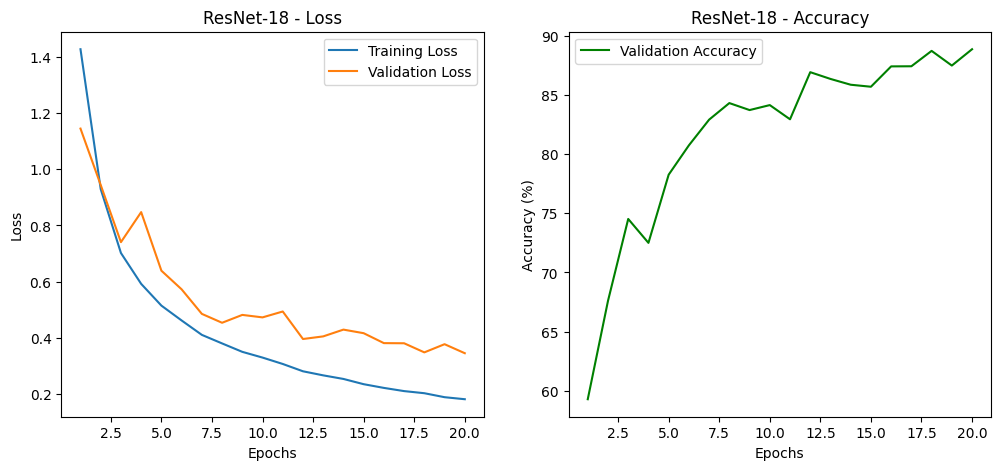

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Define Basic Residual Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.dropout = nn.Dropout(0.5) if dropout else None

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.dropout:
            out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            identity = self.downsample(identity)
        
        out += identity
        out = self.relu(out)
        return out

# Define ResNet Model
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10, dropout=False):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1, dropout=dropout)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2, dropout=dropout)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels, blocks, stride, dropout):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, dropout))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define ResNet-11 and ResNet-18 Architectures
def resnet11(num_classes=10, dropout=False):
    return ResNet([1, 1, 1, 1], num_classes, dropout)

def resnet18(num_classes=10, dropout=False):
    return ResNet([2, 2, 2, 2], num_classes, dropout)

# Plot training results
def plot_results(train_losses, val_losses, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accs, label='Validation Accuracy', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')
    
    plt.show()

# Train and evaluate models
model_resnet11 = resnet11(num_classes=10, dropout=False)
print("Training ResNet-11 on CIFAR-10...")
train_losses, val_losses, val_accs = train_model(model_resnet11, trainloader_c10, testloader_c10, epochs=20)
plot_results(train_losses, val_losses, val_accs, "ResNet-11")

model_resnet18 = resnet18(num_classes=10, dropout=False)
print("Training ResNet-18 on CIFAR-10...")
train_losses18, val_losses18, val_accs18 = train_model(model_resnet18, trainloader_c10, testloader_c10, epochs=20)
plot_results(train_losses18, val_losses18, val_accs18, "ResNet-18")


In [12]:
# Print Training Results for ResNet-11
print("\nResNet-11 Training Results:")
for epoch in range(len(train_losses)):
    print(f"Epoch {epoch+1}: Training Loss = {train_losses[epoch]:.4f}, Validation Loss = {val_losses[epoch]:.4f}, Validation Accuracy = {val_accs[epoch]:.2f}%")

# Print Training Results for ResNet-18
print("\nResNet-18 Training Results:")
for epoch in range(len(train_losses18)):
    print(f"Epoch {epoch+1}: Training Loss = {train_losses18[epoch]:.4f}, Validation Loss = {val_losses18[epoch]:.4f}, Validation Accuracy = {val_accs18[epoch]:.2f}%")



ResNet-11 Training Results:
Epoch 1: Training Loss = 1.4494, Validation Loss = 1.2192, Validation Accuracy = 57.25%
Epoch 2: Training Loss = 0.9973, Validation Loss = 1.0871, Validation Accuracy = 62.43%
Epoch 3: Training Loss = 0.8064, Validation Loss = 0.8882, Validation Accuracy = 69.12%
Epoch 4: Training Loss = 0.6826, Validation Loss = 0.6776, Validation Accuracy = 76.92%
Epoch 5: Training Loss = 0.6056, Validation Loss = 0.6327, Validation Accuracy = 78.52%
Epoch 6: Training Loss = 0.5472, Validation Loss = 0.8029, Validation Accuracy = 73.66%
Epoch 7: Training Loss = 0.4961, Validation Loss = 0.5290, Validation Accuracy = 81.89%
Epoch 8: Training Loss = 0.4619, Validation Loss = 0.5424, Validation Accuracy = 81.08%
Epoch 9: Training Loss = 0.4320, Validation Loss = 0.5647, Validation Accuracy = 80.58%
Epoch 10: Training Loss = 0.4036, Validation Loss = 0.5306, Validation Accuracy = 82.34%
Epoch 11: Training Loss = 0.3763, Validation Loss = 0.5168, Validation Accuracy = 81.91%
E